In [ ]:
import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import time
import pickle

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GlobalMaxPool1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras import Sequential, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

# Data Loading

In [ ]:
# connect to data folder
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/MyDrive/AF_detection_MIT_data") # need to change file name

Mounted at /content/gdrive


In [ ]:
# import preprocessed dataset by Alex's team
data_train = 'patient_data_100_beat_window_99_beat_overlap/train/'
data_test = 'patient_data_100_beat_window_99_beat_overlap/test/'

In [ ]:
file_list = glob.glob(data_train + '*.csv', recursive = True)

In [ ]:
patients  = [(os.path.split(i)[1]).split('_')[0] for i in file_list]

In [ ]:
patients

['08378',
 '04126',
 '05091',
 '04048',
 '04043',
 '04936',
 '06995',
 '07162',
 '05121',
 '04015',
 '07910',
 '04746',
 '06426',
 '04908',
 '08219',
 '08215',
 '07859',
 '05261',
 '06453',
 '07879']

In [ ]:
frames = [pd.read_csv(p, header = None) for p in file_list] # a patient with his data, total 20 patients
data = pd.concat(frames, ignore_index = True)

In [ ]:
data[data[0] != 0]

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
4065,1,114,115,115,115,116,116,116,118,119,...,204,204,205,206,207,208,207,211,212,130
4066,2,115,115,115,116,116,116,118,119,121,...,204,205,206,207,208,207,211,212,130,129
4067,3,115,115,116,116,116,118,119,121,120,...,205,206,207,208,207,211,212,130,129,142
4068,4,115,116,116,116,118,119,121,120,121,...,206,207,208,207,211,212,130,129,142,224
4069,5,116,116,116,118,119,121,120,121,120,...,207,208,207,211,212,130,129,142,224,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961022,5,104,108,159,107,283,305,277,295,192,...,253,267,257,249,259,255,256,261,255,251
961023,4,108,159,107,283,305,277,295,192,321,...,267,257,249,259,255,256,261,255,251,269
961024,3,159,107,283,305,277,295,192,321,273,...,257,249,259,255,256,261,255,251,269,254
961025,2,107,283,305,277,295,192,321,273,284,...,249,259,255,256,261,255,251,269,254,228


In [ ]:
print('we have {0} data points from {1} patients!'.format(data.shape, len(patients)))

we have (968303, 101) data points from 20 patients!


In [ ]:
# total number of heart beats
data.shape

(968303, 101)

# Data Preprocessing

In [ ]:
# split the data into variables and labels (0 = Non-AF, 1 = AF)
x_data = data.iloc[:,1:].values
y_data = data.iloc[:,0].values
y_data[y_data > 0] = 1

In [ ]:
x_data

array([[208, 197, 197, ..., 294, 220, 211],
       [197, 197, 199, ..., 220, 211, 210],
       [197, 199, 199, ..., 211, 210, 210],
       ...,
       [224, 227, 224, ..., 225, 222, 221],
       [227, 224, 222, ..., 222, 221, 225],
       [224, 222, 221, ..., 221, 225, 222]])

In [ ]:
print('there are {0} out of {1} samples that have at least one beat that '
      'is classified as atrial fibrillation'.format(sum(y_data), len(y_data)))

there are 438022 out of 968303 samples that have at least one beat that is classified as atrial fibrillation


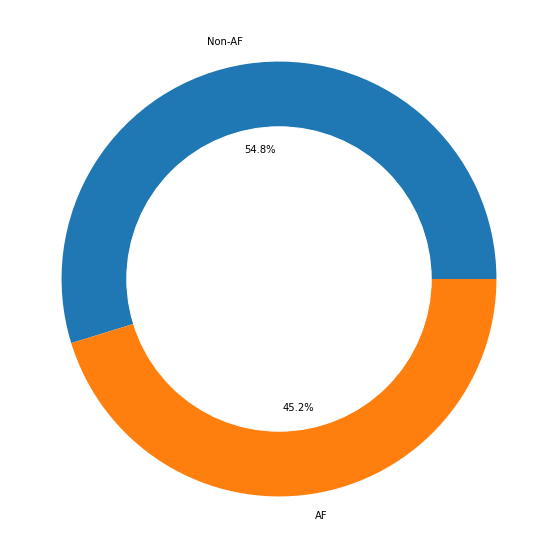

In [ ]:
y_df = pd.DataFrame(y_data).value_counts()
plt.figure(figsize = (20,10))
my_circle = plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(y_df, labels = ['Non-AF', 'AF'], colors = ['tab:blue','tab:orange'],autopct = '%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    stratify = y_data, 
                                                    test_size = 0.25,
                                                    random_state = seed)

In [ ]:
x_train

array([[150, 163, 131, ..., 152, 154, 103],
       [145, 147, 149, ..., 147, 144, 149],
       [139, 187, 149, ..., 143, 195, 150],
       ...,
       [212, 209, 214, ..., 138, 259, 213],
       [145, 142, 139, ..., 144, 146, 147],
       [131, 112, 204, ..., 135, 131, 136]])

In [ ]:
# data normalization
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

In [ ]:
# reformat the training and test sets to be able to input in the lstm 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
x_train.shape

(726227, 100, 1)

In [ ]:
# save the data with numpy so we can use it later
# datafile = './data/training_and_validation.npz'
# np.savez(datafile, 
#          x_train=x_train, x_test=x_test, 
#          y_train=y_train, y_test=y_test)

# Model Building

In [ ]:
# set the model parameters
n_timesteps = x_train.shape[1]
mode = 'concat'
n_epochs = 30
batch_size = 1024

In [ ]:
# create a stacked lstm model (bidirectional lstm + lstm)
## regularization can be considered to prevent overfitting for future use if necessary 
input = Input(shape = (n_timesteps,1,))
x = Bidirectional(LSTM(150, 
                       return_sequences = True, 
                       dropout = 0.1, 
                       recurrent_dropout = 0.1, 
                       #recurrent_regularizer=regularizers.l2(0.02),
                       #merge_mode = mode
                       ))(input)
x = LSTM(100, return_sequences = True)(x)    
# x = Dropout(0.2)(x)             
x = GlobalMaxPool1D()(x)
x = Dense(50, activation = "relu")(x)#, activity_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)
x = Dense(1, activation = 'sigmoid')(x)#, activity_regularizer=regularizers.l2(0.01))(x)
model = Model(inputs = input, outputs = x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 300)         182400    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          160400    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0     

In [ ]:
# set the optimiser
opt = Adam()

In [ ]:
# compile model
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
# set up a model checkpoint callback (including making the directory where to save our weights)
# set up a model earlystop with 5 patience (model will stop training as 'val_loss did not improve from previous epoch' occurs 5 times)
directory = './model/initial_runs_{0}/'.format(time.strftime("%Y%m%d_%H%M"))
os.makedirs(directory)
filename  = 'af_lstm_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
check_pointer = ModelCheckpoint(filepath = directory+filename, 
                               verbose = 1, 
                               save_best_only = True)
early_stop = EarlyStopping(monitor = 'val_loss', 
                          patience = 5, 
                          verbose = 1)

In [ ]:
# fit the model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    verbose = 1,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    callbacks=[check_pointer, early_stop])

Epoch 1/30
710/710 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9144
Epoch 1: val_loss improved from inf to 0.11782, saving model to ./model/initial_runs_20221012_1205/af_lstm_weights.01-0.12.hdf5
710/710 [==============================] - 548s 747ms/step - loss: 0.2084 - accuracy: 0.9144 - val_loss: 0.1178 - val_accuracy: 0.9536
Epoch 2/30
710/710 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9802
Epoch 2: val_loss improved from 0.11782 to 0.05593, saving model to ./model/initial_runs_20221012_1205/af_lstm_weights.02-0.06.hdf5
710/710 [==============================] - 521s 734ms/step - loss: 0.0575 - accuracy: 0.9802 - val_loss: 0.0559 - val_accuracy: 0.9807
Epoch 3/30
710/710 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9858
Epoch 3: val_loss did not improve from 0.05593
710/710 [==============================] - 508s 716ms/step - loss: 0.0420 - accuracy: 0.9858 - val_loss: 0.0582 - val_accuracy: 0.9798


In [ ]:
# get the best validation accuracy
best_accuracy = max(history.history['val_accuracy'])
print('best validation accuracy = {0:f}'.format(best_accuracy))

best validation accuracy = 0.988305


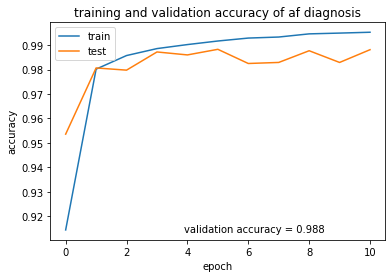

In [ ]:
import matplotlib.pyplot as plt

# plot the results
# plot validation accuracy 
f1 = plt.figure()
ax1 = f1.add_subplot(111)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('training and validation accuracy of af diagnosis')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.text(0.4, 0.05, 
         ('validation accuracy = {0:.3f}'.format(best_accuracy)), 
         ha='left', va='center', 
         transform=ax1.transAxes)
plt.savefig('af_lstm_training_accuracy_{0}.png'
            .format(time.strftime("%Y%m%d_%H%M")))

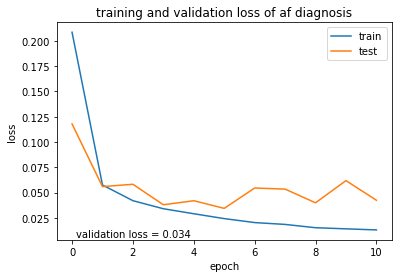

In [ ]:
# print validation loss
f2 = plt.figure()
ax2 = f2.add_subplot(111)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training and validation loss of af diagnosis')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.text(0.4, 0.05, 
         ('validation loss = {0:.3f}'
          .format(min(history.history['val_loss']))), 
         ha='right', va='top', 
         transform=ax2.transAxes)
plt.savefig('af_lstm_training_loss_{0}.png'
            .format(time.strftime("%Y%m%d_%H%M")))

In [ ]:
history.history['accuracy']

[0.914415180683136,
 0.9802004098892212,
 0.985756516456604,
 0.9886013865470886,
 0.9902440905570984,
 0.9917036890983582,
 0.9929057955741882,
 0.9933313131332397,
 0.9946242570877075,
 0.9949423670768738,
 0.9952893257141113]

In [ ]:
history.history['loss']

[0.20837722718715668,
 0.057518765330314636,
 0.04201393947005272,
 0.03406301140785217,
 0.029121046885848045,
 0.024323541671037674,
 0.02039741724729538,
 0.01857607811689377,
 0.015325365588068962,
 0.014208758249878883,
 0.013148670084774494]

In [ ]:
history.history['val_accuracy']

[0.9535971879959106,
 0.9806796312332153,
 0.9797832369804382,
 0.9872189164161682,
 0.9860126376152039,
 0.9883053302764893,
 0.9825055003166199,
 0.9829351305961609,
 0.9877228736877441,
 0.9829309582710266,
 0.9881483316421509]

In [ ]:
history.history['val_loss']

[0.11782262474298477,
 0.055930640548467636,
 0.05823503062129021,
 0.037980951368808746,
 0.041985347867012024,
 0.03443276137113571,
 0.05452558025717735,
 0.05343681573867798,
 0.03992027789354324,
 0.061819836497306824,
 0.04244561493396759]

In [ ]:
pred = model.predict(x_test)

In [ ]:
pred_ = []

for i in range(len(pred)):
  if pred[i] >= 0.5:
    pred_.append(1)
  else:
    pred_.append(0)

In [ ]:
# generate classification report for model evaluation
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, pred_, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    132570
           1       0.99      0.98      0.99    109506

    accuracy                           0.99    242076
   macro avg       0.99      0.99      0.99    242076
weighted avg       0.99      0.99      0.99    242076



In [ ]:
# generate confusion matrix for model evaluation
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, pred_, labels = [0, 1])

array([[131446,   1124],
       [  1745, 107761]])

In [ ]:
# generate AUC score for model evaluation
from sklearn.metrics import roc_auc_score

In [ ]:
auc = np.round(roc_auc_score(y_test, pred), 3)
print('AUC for our sample data is {}'.format(auc))

AUC for our sample data is 0.998
